In [36]:
from tkinter import Tk
from tkinter import filedialog as fd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from functions import *

from itertools import count
from os import times

***

The first block is for making a dataframe of all the sent messages and mark the data about the time they were sent, about the user that sent them, the chat they were sent in and the message itself.

In [136]:
def transcript_text_to_lines(input_filepath):
    '''
    takes: filepath
    returns: list of lines, chat name
    '''
    
    # Loads the text into a list
    with open(input_filepath, 'r', encoding="utf8") as f:
        chat_lines = f.readlines()
        f.close()

    # Removes the first line if it is an administrative message
    if ':' not in chat_lines[0][20:]:
        chat_lines.remove(chat_lines[0])

    # Gets the name of the chat
    chat_name = input_filepath[input_filepath.rfind('WhatsApp Chat with '):]
    
    return chat_lines, chat_name


# time stamp index = 17 (or 19 if in Croatian)
def chat_lines_to_dictionary(chat_lines, chat_name, time_stamp_index):
    '''
    takes: list of chat_lines, name of the chat, end index of the time stamp
    returns: dictionary of messages
    '''

    # Dictionary for storing all the messages
    message_dict = {
        'timestamp': [],
        'chat_name': [],
        'sender': [],
        'contents': []
    }
    
    for line in chat_lines:
        # If a line is a valid new message
        if (len(line) > time_stamp_index+2) and (line[2] in '/.') and (':' in line[20:]):
            message_dict['chat_name'].append(chat_name)
            
            message_dict['timestamp'].append(line[:time_stamp_index])
            line = line[time_stamp_index+3:]
            
            message_dict['sender'].append(line[:line.find(':')])
            line = line[line.find(':') + 2:]
            
            message_dict['contents'].append(line)
        # If a line is a continuation of the previous message
        else:
            if message_dict['contents']:
                message_dict['contents'][-1] += line

    return message_dict


# Turns the dictionary into a dataframe
def chat_dicionary_to_dataframe(message_dict):
    message_dataframe = pd.DataFrame(message_dict)
    return message_dataframe


# General function to turn a filepath into a dataframe
def input_filepath_to_dataframe():
    '''
    allows the user to input a filepath to a WhatsApp chat transcript
    returns a dataframe
    '''
    
    time_stamp_index = 17
    input_path = fd.askopenfilename()
    
    chat_lines, chat_name = transcript_text_to_lines(input_path)
    chat_dictionary = chat_lines_to_dictionary(chat_lines, chat_name, time_stamp_index)
    chat_df = chat_dicionary_to_dataframe(chat_dictionary)
    
    return chat_df

***

The second block is for making the analysis of the user count, acctualy how many messages each user has sent

In [137]:
### Functions for plotting the number of messages sent by each user ###

def make_user_message_count_dataframe(message_dataframe):
    # Count the number of messages sent by each user and turn into a dataframe
    user_message_count_df = message_dataframe['sender'].value_counts().reset_index()
    user_message_count_df.columns = ['sender', 'message_count']
    
    return user_message_count_df
    

def plot_user_message_counts(user_message_count_df, y_offset = 25, x_offset = 0.22, font_size = 15, x_size = 60, y_size = 30, chat_name = ''):
    # Manually specify colors for each user
    colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'cyan']
    
    plt.figure(figsize=(x_size, y_size))
    bars = plt.bar(user_message_count_df['sender'], user_message_count_df['message_count'],  color=colors[:len(user_message_count_df)])
    
    plt.xlabel('User', fontsize=30, labelpad=40)  # Increase font size and set label padding for x-axis label
    plt.ylabel('Number of Messages', fontsize=30, labelpad=50)  # Increase font size and set label padding for y-axis label
    plt.title((('Number of Messages Sent by Each User') * (chat_name == '')) + chat_name, fontsize=40, pad=50)  # Increase font size and set title padding

    # Increase font size for x-axis and y-axis ticks
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    

    # Add value annotations on top of the bars
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2 - x_offset, bar.get_height() + y_offset, str(int(bar.get_height())),
            fontsize=20, color='black')
        
    plt.savefig('user_message_count.png')
    plt.show()

***

The third block is for analysing the time each message was sent and plotting it

In [171]:
def to_ymd_date (timestamp):
    timestamp = standardise_timestamp(timestamp)
    
    day = timestamp[0:2]
    month = timestamp[3:5]
    year = timestamp[6:10]
    return f'{year}-{month}-{day}'

def to_dmy_date (timestamp):
    timestamp = standardise_timestamp(timestamp)
    
    day = timestamp[8:10]
    month = timestamp[5:7]
    year = timestamp[:4]
    return f'{day}-{month}-{year}'


# 23. 03. 2018. 14:14 -> 15/03/2023, 12:56
# Standardise the timestap to the format: dd/mm/yyyy, hh:mm
def standardise_timestamp(timestamp):
    if '.' in timestamp:
        timestamp_daytime = timestamp[-7:-1] + timestamp[-1]
        timestamp = timestamp[:-7]
        
        timestamp = timestamp.replace('. ', '/')
        timestamp_daytime = timestamp_daytime.replace('. ', ', ')
        
        timestamp += timestamp_daytime

    return timestamp

# Generate a dataframe with the number of messages sent on each date
def GenerateDateFrame(messages_df, starting_date = '14/06/2019'):
    date_dict = {
        'date': [],
        'number_of_messages': []
    }
    
    earliest = to_ymd_date(messages_df.iloc[0]['timestamp'])

    for i in pd.date_range(start=earliest,end=to_ymd_date(messages_df.iloc[-1]['timestamp'])):
        date_dict['date'].append(to_dmy_date(str(i)[:10]))
        date_dict['number_of_messages'].append(0)

    messages = messages_df.reset_index(drop=True)

    for index, row in messages.iterrows():
        if to_dmy_date(to_ymd_date(row['timestamp'])) in date_dict['date']:
            date_dict['number_of_messages'][date_dict['date'].index(to_dmy_date(to_ymd_date(row['timestamp'])))] += 1  

    dates = pd.DataFrame(date_dict)

    dates = dates.set_index('date')

    return dates

def PlotDateDistribution(dates_df, y_offset = 25, x_offset = 0.22, font_size = 15, x_size = 60, y_size = 30, chat_name = '', color = 'red'):
    plt.figure(figsize=(x_size, y_size))
    plt.plot(dates_df.index, dates_df['number_of_messages'], color=color, marker='o', linestyle='-')

    plt.xlabel('Date', fontsize=30, labelpad=40)
    plt.ylabel('Number of Messages', fontsize=30, labelpad=50)
    plt.title((('Number of Messages Sent by Day') * (chat_name == '')) + chat_name, fontsize=40, pad=50)

    # Increase font size for x-axis and y-axis ticks
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

    # Show only a subset of dates on the x-axis
    num_dates = len(dates_df.index)
    num_ticks = 5  # Number of ticks to show
    step = num_dates // num_ticks
    plt.xticks(range(0, num_dates, step), dates_df.index[::step])

    # Add date labels above peaks of extreme values
    for i, value in enumerate(dates_df['number_of_messages']):
        if value > 300:
            plt.text(i, value + y_offset, dates_df.index[i], fontsize=font_size, ha='center')

    plt.show()

In [144]:
chat_df = input_filepath_to_dataframe()

In [ ]:
user_message_count_df = make_user_message_count_dataframe(chat_df)

plot_user_message_counts(user_message_count_df, y_offset = 25, x_offset = 0.22, font_size = 15, x_size = 60, y_size = 30, chat_name = 'geto 8.c')

In [157]:
dates_df = GenerateDateFrame(chat_df)

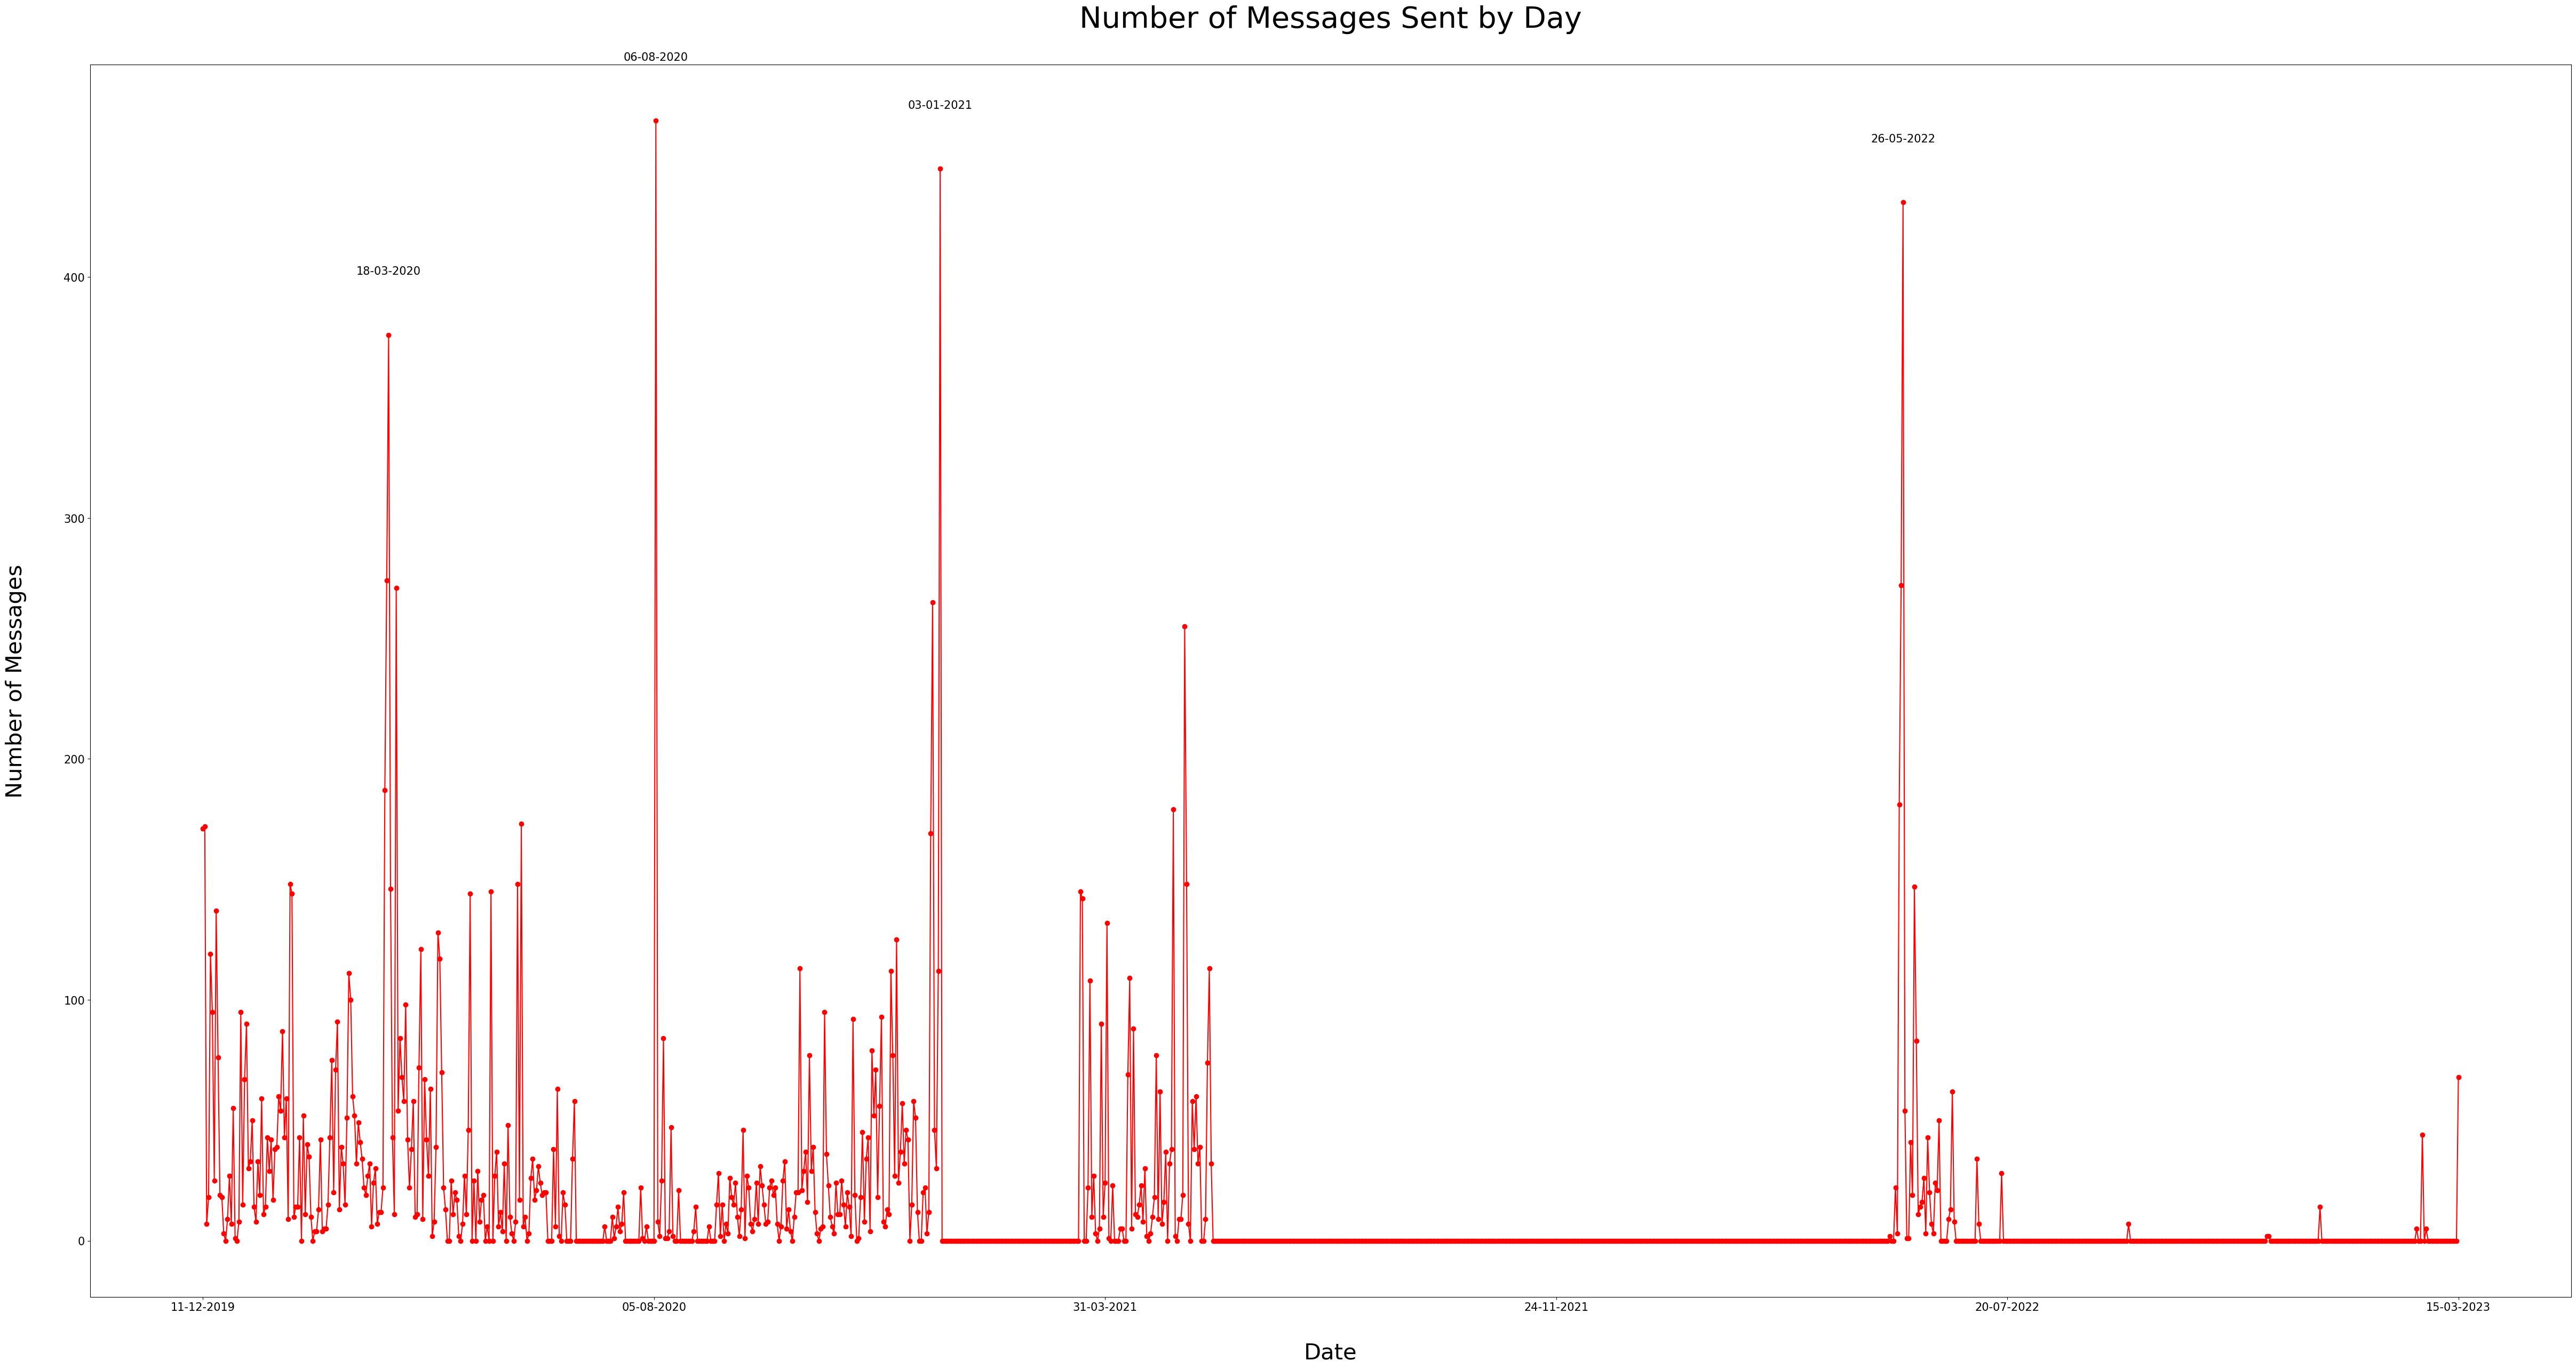

In [183]:
PlotDateDistribution(dates_df, y_offset = 25, x_offset = 0.22, font_size = 15, x_size = 60, y_size = 30, chat_name = '', color = 'red')